In [1]:
library(glmnet)
library(ggplot2)
library(dplyr)
library(reshape2)
library(Boruta)
library(survival)
library(broom)
library(rms)

Loading required package: Matrix

Loaded glmnet 4.1-10


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'rms' was built under R version 4.5.2"
Loading required package: Hmisc

Warning message:
"package 'Hmisc' was built under R version 4.5.2"

Attaching package: 'Hmisc'


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units




In [2]:
data = read.csv("final_imputed_with_sofa_firsticu.csv")

In [3]:
head(data)

,gender,age,red_blood_cells,hemoglobin,rdw,hematocrit,neutrophils,lymphocytes,platelets,alt,⋯,charlson_index,crrt_used,vasoactive_used,weight_admit,survival_time,outcome,survival_30,tibc_quantile_group,ferritin_quantile_group,iron_quantile_group
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,75.59,3.00,9.2,17.6,27.2,77.0,14.0,115,7,⋯,12,0,1,93.0,28,1,0,1,3,3
2,0,67.78,3.91,11.3,16.1,35.7,89.3,15.5,525,25,⋯,9,0,0,70.5,75,1,1,2,2,3
3,1,85.47,4.35,13.8,15.5,40.4,39.0,59.0,120,134,⋯,8,0,1,72.5,1,1,0,2,4,2
4,1,67.85,3.67,10.6,16.2,33.3,90.6,2.8,371,33,⋯,9,0,1,61.9,563,1,1,2,4,4
5,1,60.83,2.60,8.7,24.1,25.6,93.2,96.0,46,109,⋯,7,0,0,100.8,22,1,0,3,4,4
6,0,68.67,5.30,8.3,23.5,34.7,78.6,8.0,295,93,⋯,10,0,1,78.9,0,1,0,4,1,1


In [4]:
X <- data %>% select(-c(survival_time, outcome, survival_30,iron,ferritin,tibc,sofa_score,charlson_index))  # 删除多列\
# X <- data %>% select(-c(survival_time, outcome, survival_30))
X <- as.matrix(X)

y <- data$survival_30

In [ ]:
set.seed(3409)  # 设置随机种子保证结果可重复
boruta_result <- Boruta(X, y, doTrace = 2)  # doTrace=2显示详细过程

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

After 13 iterations, +8.7 secs: 

 confirmed 14 attributes: albumin, anion_gap, bun, chloride, creatinine and 9 more;

 rejected 10 attributes: arterial_embolization, crrt_used, diabetes, gender, heart_failure and 5 more;

 still have 28 attributes left.


 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

After 17 iterations, +11 secs: 

 confirmed 3 attributes: hemoglobin, temperature, vasoactive_used;

 rejected 7 attributes: aki, hyperlipidemia, mi, neutrophils, sepsis and 

In [5]:
confirmed_vars <- getSelectedAttributes(boruta_result, withTentative = FALSE)
print(confirmed_vars)

ERROR: Error: object 'boruta_result' not found


In [6]:
# 提取重要性分数
importance <- attStats(boruta_result)
importance$feature <- rownames(importance)

# 创建重要性图表
ggplot(importance, aes(x = reorder(feature, meanImp), y = meanImp, fill = decision)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Boruta特征重要性", x = "特征", y = "平均重要性") +
  scale_fill_manual(values = c("Confirmed" = "green", "Tentative" = "blue", "Rejected" = "red")) +
  theme_minimal()

ERROR: Error: object 'boruta_result' not found


In [7]:
# 提取重要性数据
imp_df <- as.data.frame(boruta_result$ImpHistory)

# 转换为长格式便于ggplot绘图
library(tidyr)
imp_long <- gather(imp_df, feature, importance)

# 绘制箱线图
ggplot(imp_long, aes(x = reorder(feature, importance, median), y = importance)) +
  geom_boxplot(aes(fill = feature), show.legend = FALSE) +
  coord_flip() +
  labs(title = "Variable Importance", x = "Feature", y = "Importance") +
  theme_classic() +
  theme(text = element_text(family = "Arial", size = 12),  # 设置整体字体为Arial
        plot.title = element_text(size = 14, hjust = 0.5),  # 标题样式
        axis.title = element_text(size = 12),  # 坐标轴标题
        axis.text = element_text(size = 10))  # 坐标轴文本

ggsave("plot1.png", dpi = 300, type = "cairo",width = 12, height = 10)

ERROR: Error: object 'boruta_result' not found


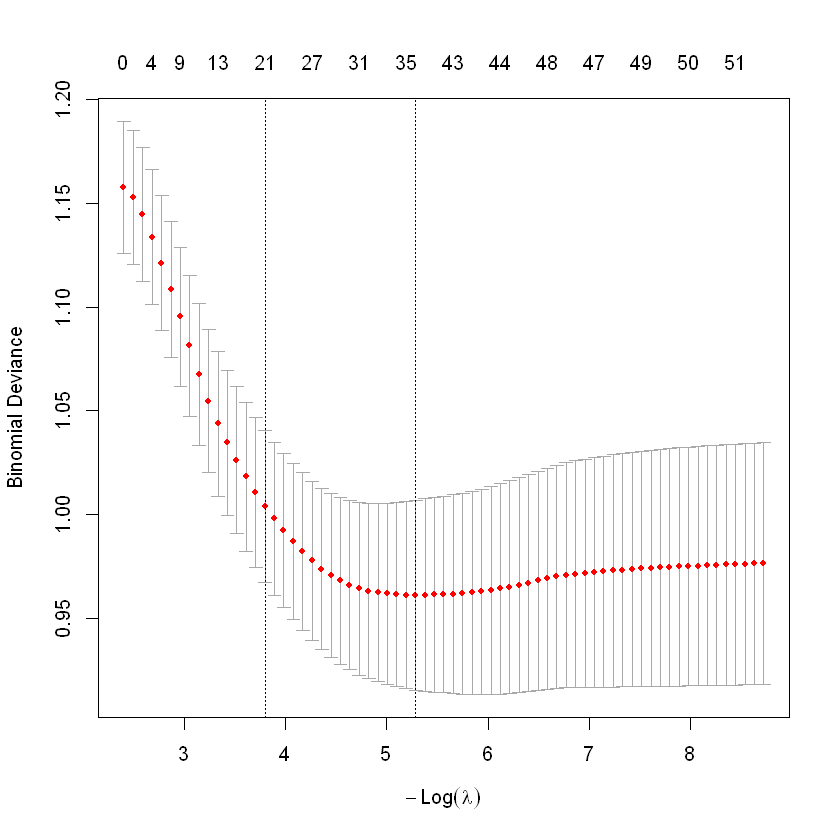

In [8]:
lasso_cv <- cv.glmnet(X, y, alpha = 1, standardize = TRUE, nfolds = 10, family = "binomial")
plot(lasso_cv) # 绘制Lasso回归的交叉验证结果图

Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"


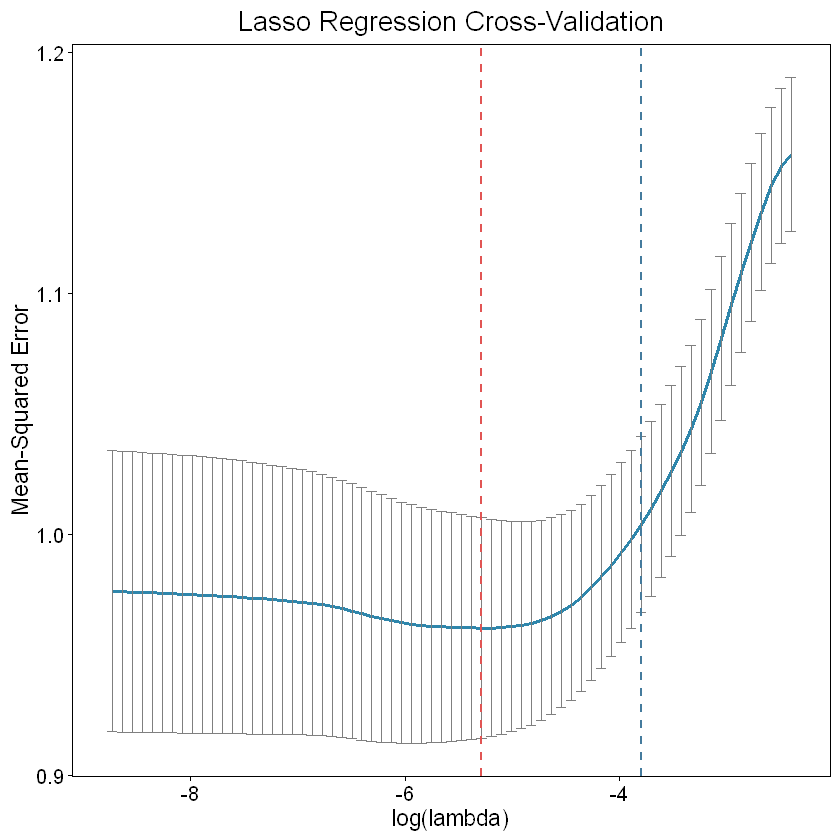

In [9]:
cv_data <- data.frame(
  lambda = log(lasso_cv$lambda),
  cvm = lasso_cv$cvm,
  cvsd = lasso_cv$cvsd,
  cvup = lasso_cv$cvm + lasso_cv$cvsd,
  cvlo = lasso_cv$cvm - lasso_cv$cvsd
)

# 绘制交叉验证误差图
ggplot(cv_data, aes(x = lambda, y = cvm)) +
  geom_line(color = "#2E86AB", linewidth = 1) +
  geom_errorbar(aes(ymin = cvlo, ymax = cvup), width = 0.1, color = "gray50") +
  geom_vline(
    xintercept = log(lasso_cv$lambda.min),
    color = "#E15554",
    linetype = "dashed",
    linewidth = 0.8
  ) +
  geom_vline(
    xintercept = log(lasso_cv$lambda.1se),
    color = "#457B9D",
    linetype = "dashed",
    linewidth = 0.8
  ) +
  labs(
    title = "Lasso Regression Cross-Validation",
    x = "log(lambda)",
    y = "Mean-Squared Error"
  ) +
  theme_classic() +
  theme(
    text = element_text(family = "Arial",size = 13),  # 设置所有文本为Arial
    plot.title = element_text(hjust = 0.5, family = "Arial",size = 16),  # 标题样式
    axis.title = element_text(family = "Arial",size = 14),  # 坐标轴标题
    axis.text = element_text(family = "Arial",size = 12),  # 坐标轴文本
    panel.border = element_rect(color = "black", fill = NA, linewidth = 0.5)
  )
ggsave("plot2.png", dpi = 300, type = "cairo",width = 8, height = 6)

In [10]:
options(device = function() {
  png(width = 1200, height = 900, res = 150)  # 提高分辨率
})

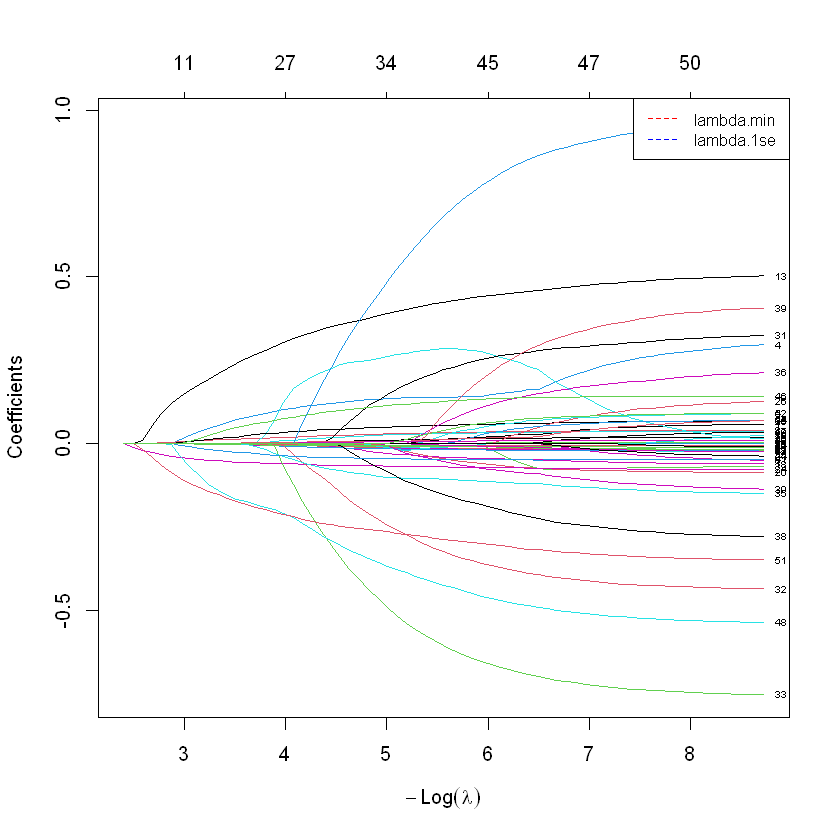

In [11]:
lasso_model <- glmnet(X, y, alpha = 1, standardize = TRUE, family = "binomial")

# 绘制系数路径图
plot(lasso_model, xvar = "lambda", label = TRUE)
# 添加最优lambda的垂直线
abline(v = log(lasso_cv$lambda.min), col = "red", lty = 2)
abline(v = log(lasso_cv$lambda.1se), col = "blue", lty = 2)
# 添加图例
legend("topright", legend = c("lambda.min", "lambda.1se"), 
       col = c("red", "blue"), lty = 2, cex = 0.8)

Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"


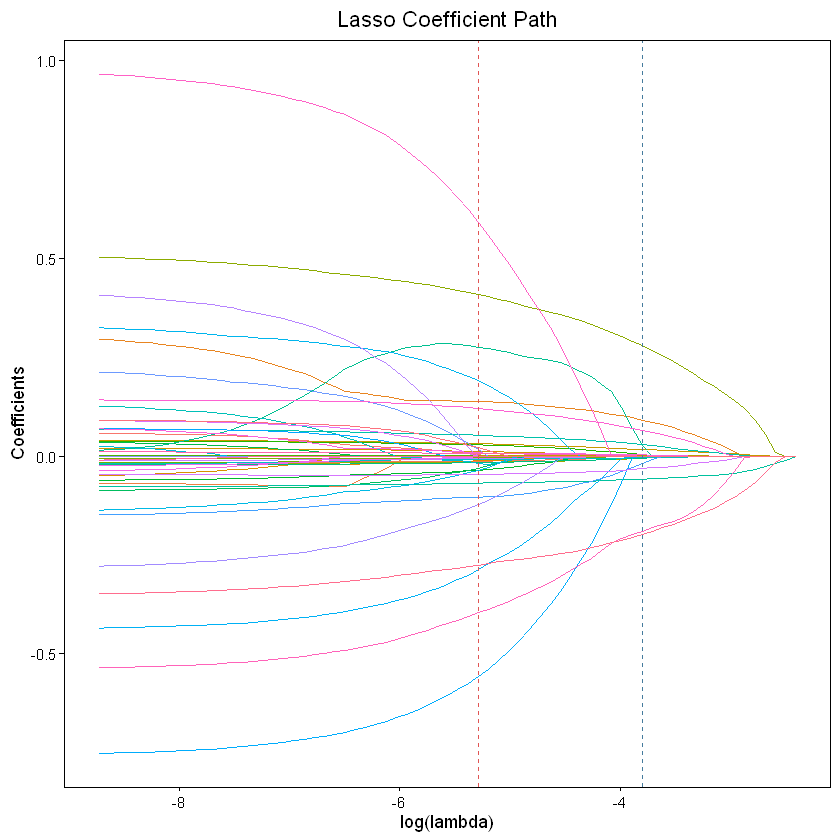

In [12]:
library(ggplot2)
library(reshape2)

# 提取系数数据
coef_data <- as.matrix(lasso_model$beta)
coef_df <- melt(coef_data)
names(coef_df) <- c("Variable", "Step", "Coefficient")
coef_df$Lambda <- rep(log(lasso_model$lambda), each = nrow(coef_data))

# 创建ggplot对象
ggplot(coef_df, aes(x = Lambda, y = Coefficient, group = Variable, color = Variable)) +
  geom_line() +
  geom_vline(xintercept = log(lasso_cv$lambda.min), color = "#E15554", linetype = "dashed") +
  geom_vline(xintercept = log(lasso_cv$lambda.1se), color = "#457B9D", linetype = "dashed") +
  # annotate("text", x = log(lasso_cv$lambda.min), y = max(coef_df$Coefficient), 
  #          label = "lambda.min", color = "red", hjust = -0.1, vjust = 1) +
  # annotate("text", x = log(lasso_cv$lambda.1se), y = max(coef_df$Coefficient), 
  #          label = "lambda.1se", color = "blue", hjust = -0.1, vjust = 2) +
  labs(x = "log(lambda)", y = "Coefficients", title = "Lasso Coefficient Path") +

  theme_classic() +  #
  theme(
    plot.title = element_text(hjust = 0.5),
        panel.border = element_rect(color = "black", fill = NA, linewidth = 0.5),
        legend.position = "none"  # 添加四边边框
  )
ggsave("plot3.png", dpi = 300, type = "cairo",width = 8, height = 6)

In [13]:
# 查看lambda.min对应的系数
coef(lasso_cv, s = "lambda.min")

# 查看lambda.1se对应的系数
coef(lasso_cv, s = "lambda.1se")

53 x 1 sparse Matrix of class "dgCMatrix"
                               lambda.min
(Intercept)                 -1.750696e+01
gender                       3.702248e-03
age                         -1.260577e-02
red_blood_cells              .           
hemoglobin                   1.387283e-01
rdw                         -1.192029e-02
hematocrit                   .           
neutrophils                  1.199904e-02
lymphocytes                  3.152132e-02
platelets                    1.890775e-03
alt                          .           
ast                         -1.264873e-04
total_bilirubin             -1.526345e-02
albumin                      4.097023e-01
bun                         -4.214305e-03
creatinine                  -1.301433e-04
glucose                      4.784796e-04
sodium                       2.887432e-02
chloride                    -3.567734e-02
free_calcium                 .           
total_calcium               -2.995307e-02
pao2                         .    

53 x 1 sparse Matrix of class "dgCMatrix"
                               lambda.1se
(Intercept)                 -6.590113e+00
gender                       .           
age                         -3.662266e-03
red_blood_cells              .           
hemoglobin                   9.143450e-02
rdw                          .           
hematocrit                   .           
neutrophils                  .           
lymphocytes                  1.714208e-02
platelets                    1.059441e-03
alt                          .           
ast                         -2.349757e-05
total_bilirubin             -5.367020e-03
albumin                      2.806260e-01
bun                         -1.203423e-03
creatinine                   .           
glucose                      .           
sodium                       4.238054e-03
chloride                     .           
free_calcium                 .           
total_calcium                .           
pao2                         .    

In [ ]:
# 提取lambda.min对应的系数
coef_values <- coef(lasso_cv, s = "lambda.min")

# 转换为数据框
coef_df <- data.frame(
  feature = rownames(coef_values),
  coefficient = as.vector(coef_values)
)

# 去掉截距项(通常命名为"(Intercept)")，并过滤掉系数为0的特征
coef_df <- coef_df[coef_df$feature != "(Intercept)" & coef_df$coefficient != 0, ]

# 按系数绝对值降序排序
coef_df <- coef_df[order(abs(coef_df$coefficient), decreasing = TRUE), ]

# 绘制特征重要性图
library(ggplot2)
ggplot(coef_df, aes(x = reorder(feature, coefficient), 
                    y = coefficient, 
                    fill = ifelse(coefficient > 0, "Positive", "Negative"))) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Lasso Regression Feature Importance (lambda.min)", 
       x = "Features", 
       y = "Coefficient Value",
       fill = "Direction") +
  scale_fill_manual(values = c("Negative" = "red", "Positive" = "blue")) +
  theme_minimal() +
  theme(legend.position = "top")

In [ ]:
plot(fit, xvar = "lambda", label = TRUE)
# 添加标题和坐标轴标签
title("Lasso回归系数路径图")
# 添加图例（如果需要）